# [HIGGS UCI](https://archive.ics.uci.edu/ml/datasets/HIGGS#) 

In this notebook will work with real dataset from high energy physics (HEP). The goal is increase the accuracy on test subset compared to baseline. 

### Introduction

The field of high energy physics is devoted to the study of the elementary constituents of matter. By investigating the structure of matter and the laws that govern its interactions, this field strives to discover the fundamental
properties of the physical universe. The primary tools of experimental high energy physicists are modern accelerators, which collide protons and/or antiprotons to create exotic particles that occur only at extremely high
energy densities. Collisions at high energy particle colliders are a fruitful source of exotic particle discoveries. Observing these particles and measuring their properties may yield critical insights about the
very nature of matter. Finding these rare particles requires solving difficult signal-versus-background classification problems.  Such discoveries require powerful statistical methods, and machine learning tools play
a critical role. Given the limited quantity and expensive nature of the data, improvements in analytical tools
directly boost particle discovery potential.

### Data Set Information:

The data has been produced using Monte Carlo simulations. 

The first column is the class label:
- 1 for signal, 
- 0 for background.

Other 28 columns are features (21 low-level features then 7 high-level features): 
- lepton pT, 
- lepton eta, 
- lepton phi, 
- missing energy magnitude, 
- missing energy phi, 
- jet 1 pt, 
- jet 1 eta, 
- jet 1 phi, 
- jet 1 b-tag, 
- jet 2 pt, 
- jet 2 eta, 
- jet 2 phi, 
- jet 2 b-tag, 
- jet 3 pt, 
- jet 3 eta, 
- jet 3 phi, 
- jet 3 b-tag, 
- jet 4 pt, 
- jet 4 eta, 
- jet 4 phi, 
- jet 4 b-tag, 


- m_jj, 
- m_jjj, 
- m_lv, 
- m_jlv, 
- m_bb, 
- m_wbb, 
- m_wwbb.

The first 21 features (columns 1-21) are kinematic properties measured by the particle detectors in the accelerator. The last seven features are functions of the first 21 features; these are high-level features derived by physicists to help discriminate between the two classes.

The last 500,000 examples are used as a test set.

Benchmark results using Bayesian Decision Trees from a standard physics package and 5-layer neural networks are presented in the original paper:

**Baldi, P., P. Sadowski, and D. Whiteson.** “[Searching for Exotic Particles in High-energy Physics with Deep Learning](https://arxiv.org/pdf/1402.4735.pdf).” Nature Communications 5 (July 2, 2014).


In [4]:
# import packages

import pandas as pd
import numpy as np
import xgboost as xgb
import wget
from sklearn.metrics import accuracy_score

# apply pip install for those you don`t have

In [5]:
# pip install wget

In [6]:
# donwload the HIGGS dataset
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00280/HIGGS.csv.gz"  
wget.download(url, 'HIGGS.csv.gz') 

'HIGGS.csv.gz'

In [7]:
# open the dataset 

data = pd.read_csv('HIGGS.csv.gz', names=list(range(29)))

In [8]:
print('Number of rows = ', data.shape[0])
print('Number of columns = ', data.shape[1])

Number of rows =  11000000
Number of columns =  29


We will divide the data to train and test subsets. Our goal is to predict the class from the first column (with number 0).

In [9]:
from sklearn.model_selection import train_test_split

In [10]:
data[0]

0           1.0
1           1.0
2           1.0
3           0.0
4           1.0
           ... 
10999995    1.0
10999996    1.0
10999997    1.0
10999998    0.0
10999999    0.0
Name: 0, Length: 11000000, dtype: float64

The last 500 000 of samples we will use as test subset to check the perfomance of our model. The remaining dataset has 10.5 millions of observations that will require a lot of time to train the model and tune hyperparameters. That is why we will reduce the number of training samples to 1 million. Since the dataset can be imbalanced we should not extract samples randomly. We will extract samples the way that train subset will have the same classes distribution as dataset using *stratify* in **train_test_split()**.

In [11]:
# extract last 500 000 observations to test subset

X_test, y_test = data.to_numpy()[-500000:,1:], data.to_numpy()[-500000:,0]

In [21]:
# extract training set with the same distribution
# 0.2/21 is choosen to obtain 100 thousand of observations

X, y = data.to_numpy()[:-500000,1:], data.to_numpy()[:-500000,0]
X_train, X_val, y_train, y_val = train_test_split(X,y, train_size=0.2/21, random_state=42, stratify=data.to_numpy()[:-500000,0],)

Let us check if both distributions are realy coincide:

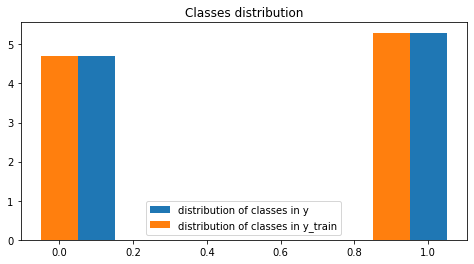

In [22]:
from matplotlib import pyplot as plt
fig = plt.figure(figsize=(8,4))
plt.hist(y,density=True,rwidth=1,align='right',label='distribution of classes in y');
plt.hist(y_train,density=True,rwidth=1,align='left',label='distribution of classes in y_train');
plt.legend()
plt.title('Classes distribution');

Yes, they are! 

### Baseline

Using the default values of hyperparametrs of [XGboost](https://xgboost.readthedocs.io/en/latest/parameter.html#) classifier we will train the model and check the accuracy on the test.

In [76]:
# init the model

clf_base = xgb.XGBClassifier(random_state=42, n_jobs=-1) #  n_jobs is an integer, specifying the maximum number of concurrently running workers
                                                         #  n_jobs=-1 means all possible workers are going to be used

In [77]:
# fit the model on the train subset
%%time
clf_base.fit(X_train, y_train)

CPU times: user 16.8 s, sys: 39.9 ms, total: 16.9 s
Wall time: 16.8 s


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [78]:
# make predictions on the test subset

pred_base = clf_base.predict(X_test)

print('Accuracy on the test is ', round(accuracy_score(pred_base, y_test),4))

Accuracy on the test is  0.7117


So, you may see that default values of hyperparameters gave us 71% of correctnes in our binary classes problem. Is it possible to increase the accuracy on the test?

**Task:** by tuning hyperparameters of the model, obtain the accuracy on the test greater or equal to 0.73. Do not forget to set random_state=42. What are the values of the hyperparameters for the best model?

- learning rate
- gamma
- maximum depth
- number of estimators

### Parameters to tune
- **learning_rate** [default=0.3]

  Parameter of the learning rate. Step size shrinkage used in update to prevents overfitting. After each boosting step, we can directly get the weights of new features, and eta shrinks the feature weights to make the boosting process more conservative. The range is [0,1].

- **gamma** [default=0]

  Parameter of the min split loss. Minimum loss reduction required to make a further partition on a leaf node of the tree. The larger gamma is, the more conservative the algorithm will be. The range is [0,∞].

- **max_depth** [default=6]

  Maximum depth of a tree. Increasing this value will make the model more complex and more likely to overfit. 0 is only accepted in lossguide growing policy when tree_method is set as hist or gpu_hist and it indicates no limit on depth. Beware that XGBoost aggressively consumes memory when training a deep tree.
 The range is [0,∞] 

- **n_estimators** [default=100]

  Number of gradient boosted trees. Equivalent to number of boosting rounds. 

## Solution

In [ ]:
# your code